# Prepare training data for Word2Vec


## Download text corpus

In [ ]:
#### we can explain Wget is a command that can retrieve files, use is like:"wget url -O output_name" 
import urllib.request
## Aim: prepare corpus file, download using url to your local storage, Wget can retrieve files from various web servers

!wget --no-check-certificate https://raw.githubusercontent.com/aisutd/Intro-to-NLP-pretrained/main/word_embedding_models/data/sample_corpus_essay_Bach_Nguyen.txt -O ./sample_corpus.txt

!wget --no-check-certificate https://raw.githubusercontent.com/aisutd/Intro-to-NLP-pretrained/main/word_embedding_models/data/shakespeare.txt -O ./shakespeare.txt

!wget --no-check-certificate https://raw.githubusercontent.com/aisutd/Intro-to-NLP-pretrained/main/word_embedding_models/data/warpeace.txt -O ./warpeace.txt


## Decode corpus into a list of words

In [ ]:
#### Can we make the loading corpus process easier? My plan is to define a function that can:  
#### process: corpus--> parse --> sentence --> word_tokenize --> [ [word1,word2,word3...forming a sentence] , [word1,word2,word3...forming a sentence] ]
#### it uses nltk library
import nltk
import tensorflow as tf
nltk.download('punkt')

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

## determine the path of training corpus
corpus_path1 = 'warpeace.txt'
corpus_path2 = 'shakespeare.txt'


## Aim: make the following transformations: 
## corpus--> parse --> sentence --> word_tokenize --> [ [word1,word2,word3...forming a sentence] , [word1,word2,word3...forming a sentence] ]
def load_corpus(corpus_path):
  f = open(corpus_path,encoding='utf-8-sig')
  content = f.read()
  ## in the warpeace.txt, there are two newline(Enter) characters between paragraphes, 
  ## so use .split('\n\n') to split paragraphs
  paragraphs = content.split('\n\n')
  sentences = []

  ## if you want to break a paragraph into sentences, could use:
  ## tokenize.sent_tokenize(paragraph) 
  ## it will break a sentence (str) into 
  ## a list of strings, each string is a sentence
  for i in paragraphs:
    sentences.extend(nltk.tokenize.sent_tokenize(i))
  
  words = []
  ## to break a sentence into words
  ## could use text_to_word_sequence(i)
  for i in sentences:
    temp = text_to_word_sequence(i)
    words.append(temp)
  
  return words

corpus1 = load_corpus(corpus_path1)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Visualize this corpus decoding process

In [ ]:
## load_corpus function test 
f = open(corpus_path1,encoding='utf-8-sig')
content = f.read()
paragraphs = content.split('\n\n')
print('origional paragraph:')
print(paragraphs[0])
print()

group_of_sentence = nltk.tokenize.sent_tokenize(paragraphs[0])
print("after sent_tokenize(paragraph)")
print(group_of_sentence)
print()

group_of_words = text_to_word_sequence(group_of_sentence[0])
print("after text_to_word_sequence(sentence)")
print(group_of_words)


origional paragraph:
"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by that
Antichrist--I really believe he is Antichrist--I will have nothing more
to do with you and you are no longer my friend, no longer my 'faithful
slave,' as you call yourself! But how do you do? I see I have frightened
you--sit down and tell me all the news."

after sent_tokenize(paragraph)
['"Well, Prince, so Genoa and Lucca are now just family estates of the\nBuonapartes.', "But I warn you, if you don't tell me that this means war,\nif you still try to defend the infamies and horrors perpetrated by that\nAntichrist--I really believe he is Antichrist--I will have nothing more\nto do with you and you are no longer my friend, no longer my 'faithful\nslave,' as you call yourself!", 'But how do you do?', 'I see I have frightened\nyou--sit down and tell me all the

## Give each unique word an index
so later, we can use index to present any word 

For example: ['before', 'we', 'proceed', 'any','further', 'hear', 'me', 'speak'] --> [138, 36, 982, 144, 673, 125, 16, 106]

In [ ]:
## use tokenizer to give each word in corpus a unique index
tokenizer = Tokenizer(oov_token='<OOV>')
## tokenizer.fit_on_texts(corpus)
tokenizer.fit_on_texts(corpus1)
w2id = tokenizer.word_index


In [ ]:
len(w2id)


18283

## Generating embeddings training data
  - The inputs (features) are surrounding words 
  - The output (predictions) is the target word

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
window_size = 2

In [ ]:
import random
import numpy as np
def generate_pairs(window_size, corpus):
  ## line_num: how many lines to use as training data from our corpus
  line_num = 600
  
  ## randomly choose lines from corpus
  random.shuffle(corpus)
  corpus = corpus[:line_num]
  
  X = []
  y = []

  for words in corpus:
    start = 0
    while start + window_size * 2 < len(words):
      end = start + window_size * 2
      tar_i = start + window_size
      x = [" ".join(words[start:tar_i] + words[tar_i+1:end+1])]
      label = words[tar_i]
      # print(words)
      # print(x, "--->", label)
      start += 1
      X.append(tokenizer.texts_to_sequences(x)[0])
      y.append(to_categorical( tokenizer.word_index[label], len(tokenizer.word_index) + 1))

  return tf.convert_to_tensor(X) , tf.convert_to_tensor(y)


In [ ]:
X_train, y_train = generate_pairs(window_size, corpus1)


In [ ]:
X_train

In [ ]:
y_train

## CBOW model
1. defind model structure: 
- defining each layer
- defining how input data flows from layer to layer
- defining loss function
2. train model using our training data
3. upgrade weight

Model configuration: 
One Embedding (hidden) layer the size of the output embedding vectors, 
One lambda layer to calculate the mean over all embedding vectors (target vectors and context vectors)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Lambda
from tensorflow.keras.backend import mean 


In [ ]:
X_train[0], y_train[0]

(<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  3,  19, 932,  19], dtype=int32)>,
 <tf.Tensor: shape=(18284,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>)

In [ ]:
#### want to explain each layer in detail? 
#### explain the loss function?
embedding_size = 128
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: mean(x, axis=1), output_shape=(embedding_size,) ))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
cbow.fit(X_train, y_train, epochs=40, verbose=1)

In [ ]:
## model cbow have finished training

cbow.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 4, 128)            2340352   
_________________________________________________________________
lambda_2 (Lambda)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 18284)             2358636   
Total params: 4,698,988
Trainable params: 4,698,988
Non-trainable params: 0
_________________________________________________________________


*Examining the trained model and check embeddings*

In [ ]:
## model.get_weights() will get weight of all layers, here, we need the first layer
weights = cbow.get_weights()[0]

# Visualization

In [ ]:
## visualize the embedding of each word
import pandas as pd
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(tokenizer.index_word.values())).head()

(18283, 128)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
<OOV>,0.000404,0.041296,0.001973,0.020388,0.028730,-0.028484,0.030016,-0.041115,0.026272,-0.013379,-0.027312,-0.039701,-0.032826,0.034481,-0.031482,0.022481,-0.016323,-0.002279,0.046065,-0.023169,0.011711,-0.027386,0.017944,-0.009765,-0.047634,0.031039,-0.029459,-0.035880,-0.039169,-0.016874,0.018874,-0.047782,0.040012,0.037530,-0.025602,-0.039447,0.012189,0.029454,0.033225,0.045113,...,-0.043208,-0.017689,-0.040157,-0.032527,-0.045790,0.038097,0.006811,0.021862,0.034570,0.039704,0.001331,-0.023852,-0.015273,-0.018412,-0.030702,-0.017098,0.006126,-0.048408,0.047038,-0.018962,-0.044467,-0.017508,0.049819,0.045960,0.048172,-0.005494,-0.008210,0.005549,-0.022838,-0.021250,-0.033763,0.024100,-0.043886,0.009294,0.031871,0.002225,0.035638,0.014822,0.003821,-0.000264
the,-0.257736,0.293641,0.692132,0.046530,-0.018028,0.309569,0.498804,-0.751291,0.000568,-1.161633,1.399045,0.901222,1.212245,0.337493,-1.077747,0.393239,0.868459,-1.218264,-0.702668,-0.508949,1.379773,0.684562,-0.478001,1.934656,-0.640410,-1.368634,0.648364,0.432985,0.120155,-0.769256,-0.937215,0.829384,0.139868,-2.333879,0.027170,1.629406,-1.059711,0.312353,-2.309788,0.516218,...,0.003356,0.189327,-1.208838,-0.672895,-0.530488,0.119249,0.234300,0.544226,0.112984,-0.339929,0.416541,1.343238,0.105336,0.858705,-0.116132,0.280401,0.778585,1.128028,-1.609462,0.737383,0.004564,1.264146,-0.194314,0.841291,-0.112459,-1.020169,-0.341742,0.430846,-0.931552,-0.778793,-0.806238,0.835324,-0.590898,0.860698,-0.622212,0.129965,-0.928830,-1.270448,-0.074886,-0.900748
and,-0.845702,-1.450420,-1.221642,1.125943,-0.816225,-0.062149,1.751172,0.671192,1.871115,0.823485,-1.237643,-1.239474,0.622732,1.087603,0.440104,0.901239,1.464554,1.128371,-1.238841,-0.068189,-0.972308,0.227093,0.983175,-0.929632,0.615596,0.698862,0.016288,-1.057213,-0.049349,0.829984,-0.341298,-1.095851,0.847433,1.163382,-0.398383,0.195129,0.889611,-0.720562,0.687627,-0.299999,...,-0.168867,0.306315,0.714580,-0.910497,-0.519435,0.837615,0.619601,-0.741754,0.701022,0.224566,0.198512,-0.007896,-0.102169,0.885575,-1.208625,0.508875,-0.263460,0.271034,0.137292,-1.390332,-0.745570,-0.889107,0.480599,1.191729,-1.122144,0.486226,0.248608,-1.277798,-1.054769,-0.353150,-0.505930,0.093927,0.264163,-0.844490,0.429597,-1.137976,-0.800089,-0.977990,-1.547301,-0.467962
to,0.350556,-0.079439,1.021105,1.552466,-0.284418,0.761033,0.095495,2.128414,-0.256369,-1.577548,-1.561545,-0.660781,-1.552087,-1.190119,-0.128892,-1.448903,0.592595,0.811291,1.133071,0.965412,0.608937,-0.449273,0.116730,-0.416856,-0.273741,0.901183,-1.291070,1.556628,-0.707583,0.120663,0.675146,0.430638,1.022249,-0.113210,0.235896,0.674733,-0.305709,-0.530438,-0.042419,-0.406645,...,-0.286296,0.845473,-1.459607,-0.459425,0.932763,-0.995375,-1.274460,-0.422914,0.245985,0.614344,-1.274514,-1.010206,0.146373,-0.660546,0.688233,1.944947,1.123513,-1.022935,0.458373,1.011283,0.599070,-0.792976,-0.330787,-0.190308,-0.089556,0.960643,0.250992,0.778522,0.053564,-1.122532,-0.370896,0.575396,-0.447636,-0.706243,-0.192837,0.605254,-1.204168,0.931996,0.712831,1.176523
of,0.243352,0.871903,0.069889,-1.742707,0.087215,0.499025,0.678177,-0.957983,-1.232533,1.333122,-0.719711,0.525157,0.336917,-0.697553,-1.153169,-1.026292,1.221626,0.716688,1.198959,0.086602,-0.959524,0.023762,-1.279881,-0.556938,-0.238896,0.864581,1.226758,-1.348667,1.535303,-1.358394,-1.285847,-0.753889,0.413269,0.187787,-0.113171,0.127241,-0.342945,0.794270,-0.415729,1.460319,...,0.093836,1.296466,-0.998680,-0.710773,1.798364,-0.409993,-1.392506,-1.459902,-0.468733,-0.103662,1.523205,-0.101150,1.139579,-0.920750,0.441831,-1.018171,-0.345307,1.036974,-0.437520,0.448377,-1.541105,-0.638920,-1.151975,-0.591554,-0.536341,0.482482,0.723538,-0.683353,-0.503783,1.0

In [ ]:
weights.shape

(18283, 128)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
#### might take 15 mins, while weights.shape is (18283, 128)
## TSNE model is a way to visualize the high dementional embeddings 
## use TSNE to transfer high dementional embeddings into a 2 dementional graph, similar embeddings are closer
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_2d = tsne_model_2d.fit_transform(weights)
vocab_embeddings_2d = pd.DataFrame(embeddings_2d, index=list(tokenizer.index_word.values()),columns = ['x-axis','y-axis'])

In [ ]:
#### I use some word to test our embeddings, add word if you wish
target_word_list = ['cat','dog','animal','law','justice','judge','create','wood','tree','forest','love','bear','masters','friends','curse','enemies']
temp_words = list(tokenizer.index_word.values())
temp_embeddings = [ embeddings_2d[temp_words.index(x)] for x in target_word_list]
vocab_embeddings_2d = pd.DataFrame(temp_embeddings, index=target_word_list,columns = ['x-axis','y-axis'])



In [ ]:
## random_words_set_2d = vocab_embeddings_2d.sample(n=30, random_state=0)
## random_words_set_2d
random_words_set_2d = vocab_embeddings_2d

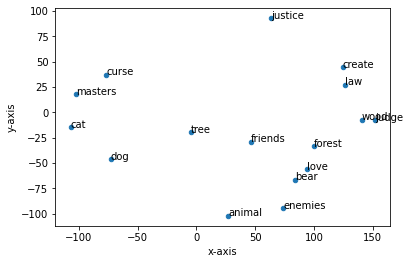

In [ ]:
#### training corpus is not large enough to show wonderful embeddings
#### but the time complexity of this algrithm do not support a large corpus
#### so how about use a pretrained embedding to show their similarity? like the GloVe code I previded

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
random_words_set_2d.plot(0, 1, kind='scatter', ax=ax)

for k, v in random_words_set_2d.iterrows():
  ax.annotate(k, v)

fig.canvas.draw()